In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

In [ ]:
pip install keras_tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
def Sliding_Window(df_temp, win_len, stride):
    """
    Sliding window function for data segmentation and label extraction.

    Args:
        df_temp (DataFrame): Input dataframe containing the data.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X (ndarray): Segmented input sequences.
        Y (ndarray): Extracted output labels.
        T (ndarray): Corresponding timestamps.
    """
    X = []  # List to store segmented input sequences.
    Y = []  # List to store extracted output labels.
    T = []  # List to store corresponding timestamps.

    # Loop through the dataframe with the specified stride.
    for i in np.arange(0, len(df_temp) - win_len, stride):
        # Extract a subset of the dataframe based on the window length.
        temp = df_temp.iloc[i:i + win_len, [3, 4]].values

        # Append the segmented input sequence to the X list.
        X.append(temp)

        # Append the output label at the end of the window to the Y list.
        Y.append(df_temp.iloc[i + win_len, -1])

        # Append the timestamp at the end of the window to the T list.
        T.append(df_temp.iloc[i + win_len, 0])

    return np.array(X), np.array(Y), np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes.

In [ ]:
def PreprocessData(working_cond, win_len, stride):
    """
    Preprocessing function to extract input sequences and output labels from CSV files of a specific working condition.

    Args:
        working_cond (str): Working condition identifier used to locate the folder containing CSV files.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X_full (ndarray): Concatenated segmented input sequences.
        Y_full (ndarray): Concatenated output labels.
    """
    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path)

    X_full, Y_full = [], []  # Lists to store concatenated segmented input sequences and output labels

    for f in file_name:  # Iterate through each file, which corresponds to a fault
        csv_path = os.path.join(Path, f)
        df = pd.read_csv(csv_path)

        temp_df_1 = df[(df.time > 1050) & (df.time < 1500)]  # Incipient - Taking samples after which the parameter fault was introduced
        x1, y1, _ = Sliding_Window(temp_df_1, win_len, stride)

        temp_df_2 = df[(df.time > 2050) & (df.time < 2500)]  # Step - Taking samples after which the parameter fault was introduced
        x2, y2, _ = Sliding_Window(temp_df_2, win_len, stride)

        x_temp, y_temp = np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2), axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)

    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1, X_full.shape[2], X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [ ]:
WL=20
S=40

# Preprocess data for working condition 120
X_120, Y_120 = PreprocessData(working_cond=120, win_len=WL, stride=S)

# Preprocess data for working condition 80
X_80, Y_80 = PreprocessData(working_cond=80, win_len=WL, stride=S)

# Preprocess data for working condition 40
X_40, Y_40 = PreprocessData(working_cond=40, win_len=WL, stride=S)

In [ ]:
# Concatenate the preprocessed data from different working conditions
X_full = np.concatenate((X_40, X_80, X_120))
Y_full = np.concatenate((Y_40, Y_80, Y_120))

# Print the length of the total data
print(f"Length of total data = {len(X_full)}")

Length of total data = 5376


In [ ]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, train_size=512, random_state=42)

# Standardising the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
# One Hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))

In [ ]:
pip install attention

# Hyper Parameter Tuning

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from attention import Attention

def build_model(hp):
    num_classes=len(encoder.categories_[0])
    # create model object
    model = Sequential([
    #adding first convolutional layer
    Conv1D(
        #adding filter
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=32),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(X_train.shape[1],X_train.shape[2]),
        padding='same'),
    # adding second convolutional layer
    MaxPooling1D(pool_size=2,padding='same'),
    # adding flatten layer
    # Flatten(),
    LSTM(units=hp.Int('lstm_1', min_value=16, max_value=128, step=32), return_sequences=True),
    Dropout(0.2),
    LSTM(units=hp.Int('lstm_2', min_value=16, max_value=128, step=32), return_sequences=True),
    LSTM(units=hp.Int('lstm_3', min_value=16, max_value=128, step=32), return_sequences=True),
    Dropout(0.5),
    Attention(),
    # adding dense layer
    Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer
    Dense(num_classes, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

# def build_model(hp):
  # from tensorflow.keras.models import Sequential,Model
  # from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
  # from tensorflow.keras.layers import Conv1D, MaxPooling1D
  # num_classes=len(encoder.categories_[0])
  # cnn_model = Sequential()
  # cnn_model.add(Conv1D(32, kernel_size=(3),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
  # cnn_model.add(MaxPooling1D((2),padding='same'))
  # # cnn_model.add(Flatten())
  # # cnn_model.add(LSTM(60))
  # cnn_model.add(LSTM(60, return_sequences=True))
  # cnn_model.add(LSTM(60))
  # cnn_model.add(Dropout(0.5))
  # # cnn_model.add(Dense(10, activation='softmax'))
  # cnn_model.add(Dense(128, activation='relu'))
  # cnn_model.add(Dense(num_classes, activation='softmax'))
  # cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  # return cnn_model

In [ ]:
#creating randomsearch object
tuner = kt.RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 10)

In [ ]:
# search best parameter
tuner.search(X_train_sc,y_train_ohe,epochs=20,validation_data=(X_test_sc,y_test_ohe))

Trial 10 Complete [00h 00m 49s]
val_accuracy: 0.9911595582962036

Best val_accuracy So Far: 0.9977384805679321
Total elapsed time: 00h 08m 25s


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 5
lstm_1: 16
lstm_2: 16
lstm_3: 16
dense_1_units: 48
learning_rate: 0.001
Score: 0.9977384805679321

Trial 00 summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
lstm_1: 80
lstm_2: 80
lstm_3: 16
dense_1_units: 32
learning_rate: 0.001
Score: 0.9975329041481018

Trial 05 summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
lstm_1: 16
lstm_2: 80
lstm_3: 48
dense_1_units: 128
learning_rate: 0.001
Score: 0.9975329041481018

Trial 06 summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 5
lstm_1: 48
lstm_2: 48
lstm_3: 80
dense_1_units: 80
learning_rate: 0.001
Score: 0.9975329041481018

Trial 07 summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
lstm_1: 48
lstm_2: 80
lstm_3: 16
dense_1_units: 32
learning_rate: 0.001
Score: 0.9973273277282715

Trial 03 summary
Hyperparameters:
conv_1_

In [ ]:
cnn_model=tuner.get_best_models(num_models=1)[0]
#summary of best model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 16)            176       
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 16)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 10, 16)            2112      
                                                                 
 dropout (Dropout)           (None, 10, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 16)            2112      
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            2112      
                                                        

# AI Training

In [ ]:
import tensorflow
# Define an EarlyStopping callback to monitor validation accuracy and restore best weights
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# Train the CNN model
cnn_model.fit(X_train_sc,
            y_train_ohe,
            epochs=200,
            batch_size=32,
            validation_data=(X_test_sc, y_test_ohe),
            callbacks=[callback],
            shuffle=False,verbose=1)

Epoch 1/200
16/16 [==============================] - 7s 137ms/step - loss: 0.0676 - accuracy: 0.9883 - val_loss: 0.0170 - val_accuracy: 0.9961
Epoch 2/200
16/16 [==============================] - 1s 51ms/step - loss: 0.0561 - accuracy: 0.9883 - val_loss: 0.0115 - val_accuracy: 0.9977
Epoch 3/200
16/16 [==============================] - 1s 50ms/step - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.0105 - val_accuracy: 0.9973
Epoch 4/200
16/16 [==============================] - 1s 97ms/step - loss: 0.0586 - accuracy: 0.9863 - val_loss: 0.0099 - val_accuracy: 0.9971
Epoch 5/200
16/16 [==============================] - 1s 74ms/step - loss: 0.0360 - accuracy: 0.9922 - val_loss: 0.0103 - val_accuracy: 0.9971
Epoch 6/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0474 - accuracy: 0.9883 - val_loss: 0.0118 - val_accuracy: 0.9965
Epoch 7/200
16/16 [==============================] - 1s 55ms/step - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0130 - val_accuracy: 0.9965
Epoc

In [ ]:
from sklearn.metrics import f1_score
# Perform prediction using the CNN model on the scaled test data
y_pred = cnn_model.predict(X_test_sc)

# Inverse transform the predicted labels using the encoder
y_pred = encoder.inverse_transform(y_pred)

# Calculate and print the F1 score
f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Train Sample = {len(X_train)}, The F1 score is - {f1score}")


152/152 [==============================] - 2s 4ms/step
Train Sample = 512, The F1 score is - 0.998561833642744


# Real Time Fault Diagnosis

In [ ]:
# Dictionary mapping fault labels to their corresponding numeric values
fault_label_dict = {
    'Healthy': 0,
    'I': 3,
    'I & W': 7,
    'K': 5,
    'Re': 1,
    'Re & Rm': 6,
    'Rm': 2,
    'W': 4
}

In [ ]:
'''fault_file = 'Healthy_noise_02.csv',
'I & W_noise_02.csv',
'I_noise_02.csv',
'K_noise_02.csv',
'Re & Rm_noise_02.csv',
'Re_noise_02.csv',
'Rm_noise_02.csv',
'W_noise_02.csv'''
def Predict_CNN(fault_file,working_cond, cnn_model, scaler, encoder, WL, S):
    """
    Predict fault labels using a trained CNN model.

    Args:
        fault_file (str): Name of the fault file to predict labels for.
        cnn_model (Model): Trained CNN model for fault prediction.
        scaler (Scaler): Scaler object for data normalization.
        encoder (Encoder): Encoder object for label encoding.
        WL (int): Length of the sliding window.
        S (int): Stride or step size for sliding the window.

    Returns:
        y_pred_num (ndarray): Predicted fault labels in numerical format.
        y_true_num (ndarray): True fault labels in numerical format.
        t1 (ndarray): Corresponding timestamps.
    """
    # Construct the path to the fault file
    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
    csv_path = os.path.join(Path, fault_file)
    df = pd.read_csv(csv_path)

    # Perform sliding window operation on the data
    x1, y1, t1 = Sliding_Window(df, win_len=WL, stride=S)

    # Normalize the input data using the provided scaler
    x_sc = scaler.transform(x1.reshape(-1, x1.shape[-1])).reshape(x1.shape)

    # Make predictions using the CNN model
    y_pred = cnn_model.predict(x_sc)
    y_pred = encoder.inverse_transform(y_pred)

    # Convert the predicted labels to numerical format
    y_pred_num = np.vectorize(fault_label_dict.get)(y_pred)
    y_pred_num = y_pred_num.reshape(-1)

    # Convert the true labels to numerical format
    y_true_num = np.vectorize(fault_label_dict.get)(y1)
    y_true_num = y_true_num.reshape(-1)

    return y_pred_num, y_true_num, t1

In [ ]:
def plot_online_FDI(y_pred_num, y_true_num, t1,Title):
    """
    Function to plot online fault detection and identification (FDI) results.

    Args:
        y_pred_num (ndarray): Predicted fault class values.
        y_true_num (ndarray): Actual fault class values.
        t1 (ndarray): Time values.

    Returns:
        None (displays the plot).
    """
    plt.subplots(figsize=(8, 3))

    sns.scatterplot(x=t1, y=y_pred_num, hue=y_true_num, palette="bright", edgecolor='black', alpha=0.5, s=30)

    # Add labels and title
    plt.xlabel('time (s)', fontsize=10)
    plt.ylabel('Predicted fault class', fontsize=10)

    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7])
    plt.ylim([-.5, 7.5])
    plt.legend(markerscale=1.5, bbox_to_anchor=(1.01, 1.05), title='Actual fault class', fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.axvspan(xmin=1000, xmax=1500, facecolor='r', alpha=0.2)
    plt.axvspan(xmin=2000, xmax=2500, facecolor='r', alpha=0.2)
    plt.title(Title)
    # Display the plot
    plt.show()

Introduced fault is Healthy
20/20 [==============================] - 1s 5ms/step


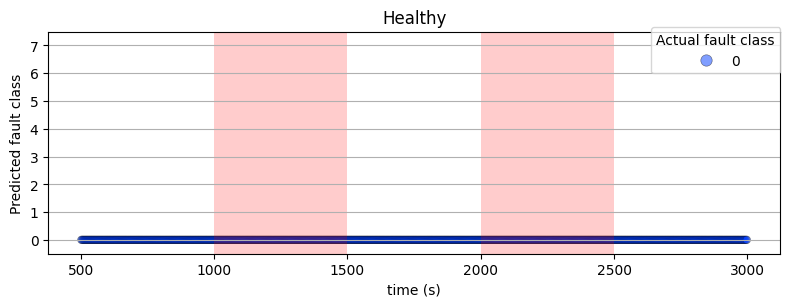

Introduced fault is I & W
20/20 [==============================] - 0s 5ms/step


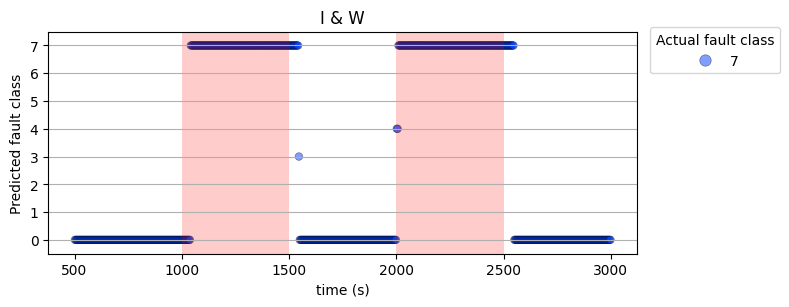

Introduced fault is I
20/20 [==============================] - 0s 4ms/step


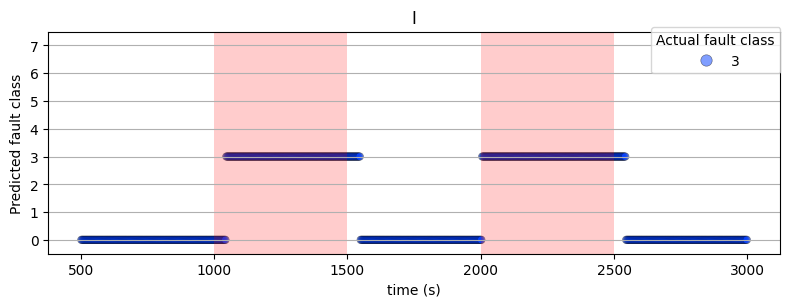

Introduced fault is K
20/20 [==============================] - 0s 4ms/step


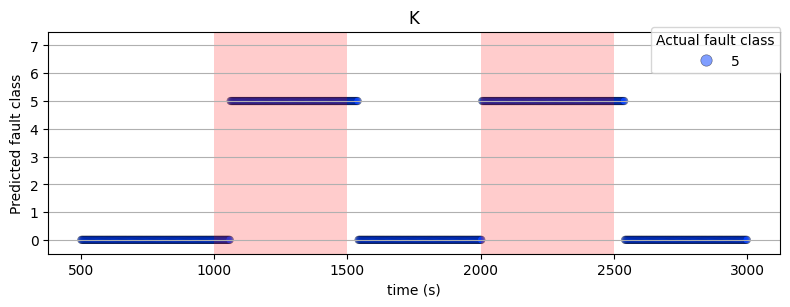

Introduced fault is Re & Rm
20/20 [==============================] - 0s 5ms/step


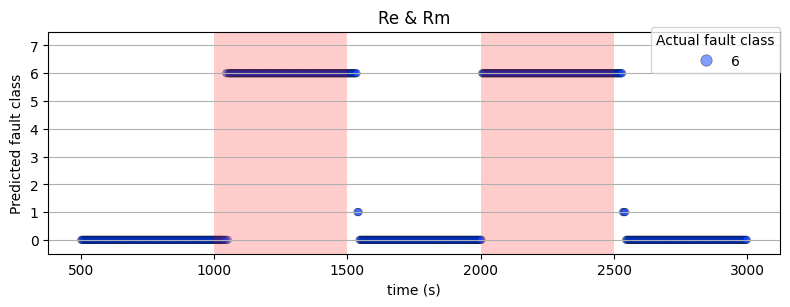

Introduced fault is Re
20/20 [==============================] - 0s 5ms/step


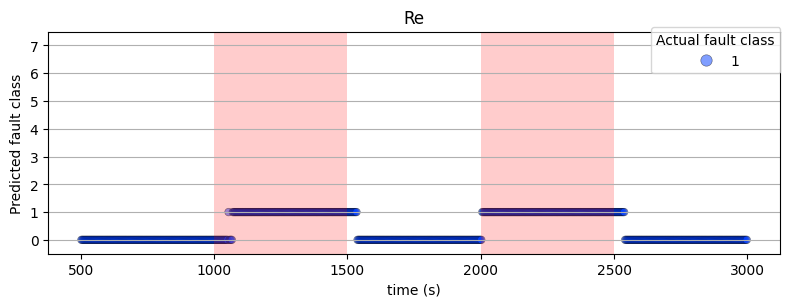

Introduced fault is Rm
20/20 [==============================] - 0s 5ms/step


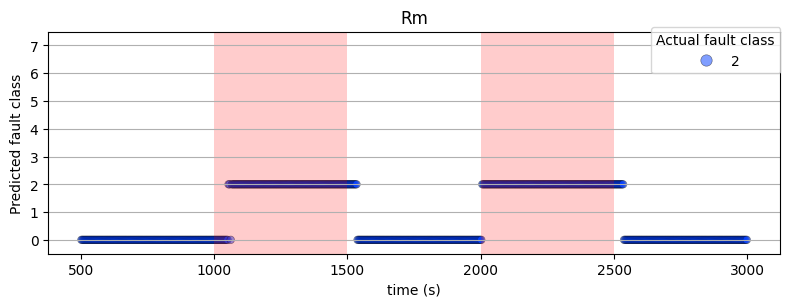

Introduced fault is W
20/20 [==============================] - 0s 5ms/step


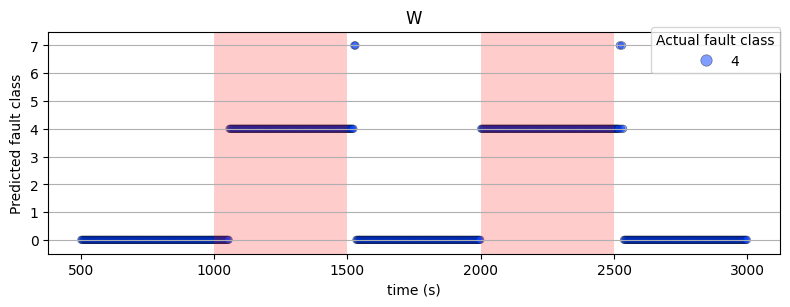

In [ ]:
file_name = ['Healthy_noise_02.csv',
            'I & W_noise_02.csv',
            'I_noise_02.csv',
            'K_noise_02.csv',
            'Re & Rm_noise_02.csv',
            'Re_noise_02.csv',
            'Rm_noise_02.csv',
            'W_noise_02.csv']

for f in file_name:
    # Extract the fault type from the file name
    fault_type = f[:-13]

    print(f"Introduced fault is {fault_type}")

    # Perform fault diagnosis using the CNN model
    y_pred_num, y_true_num, t1 = Predict_CNN(fault_file=f, working_cond=40, cnn_model=cnn_model, scaler=scaler, encoder=encoder, WL=WL, S=S)

    # Plot online fault detection and isolation results
    plot_online_FDI(y_pred_num, y_true_num, t1,Title=fault_type)